In [1]:
import numpy as np
import numpy.fft as nf
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as sc
import time as time

I2 = qt.qeye(2)
Na = 3
Ia = qt.qeye(Na)

sm = qt.tensor(Ia, qt.sigmam())
sx = qt.tensor(Ia, qt.sigmax())
sz = qt.tensor(Ia, qt.sigmaz())
a  = qt.tensor(qt.destroy(Na), I2)
II = qt.tensor(Ia, I2)

vac = qt.tensor(qt.basis(Na,0), qt.basis(2,1))

def state(n, gnd_or_exc):
    if gnd_or_exc is 'exc':
        psi = a.dag()*vac
    elif gnd_or_exc is 'gnd':
        psi = vac
    else:
        raise ValueError('Poor state definition')
    for ii in range(n):
        psi = a.dag()*psi
    return psi

options = qt.Options()
options.nsetps = 10000


class parameters(object):
    
    def __init__(self, w_cav=6e3, gamma=5e0, kappa=5e0, g=1e-1, **kwargs):
        
        self.args = {'w_qubit': 0,
                     'w_cav'  : w_cav,
                     'g'      : g,
                     'gamma'  : gamma,
                     'kappa'  : kappa,
                     'w_pump' : 0,
                     'e_pump' : 0,
                     **kwargs}
        self._compute()
        for keys in self.args.keys():
            self.args[keys] = 2*np.pi*self.args[keys]
            
        self.driv = {''}
            
    def _compute(self):
        
        self.args['d_cav'] = self.args['w_cav'] - self.args['w_pump']/2
        self.args['d_qubit'] = self.args['w_qubit'] - self.args['w_qubit']/2
            
    def update(self, **kwargs):
        
        for keys in kwargs:
            kwargs[keys] = 2*np.pi*kwargs[keys]
            
        self.args.update(**kwargs)
        self._compute()
            
    def print_args(self, where):
        pargs = {}
        if where is 'inline':
            largs = {'w_qubit':'wq', 'w_cav':'wc',
                     'w_pump':'wp', 'e_pump':'ep',
                     'gamma':'gamma', 'kappa':'kappa', 'g':'g',
                     'd_cav':'dcav', 'd_qubit':'dqbit'}
        elif where is 'plot':
            largs = {'w_qubit':r'$\omega_q$', 'w_cav':r'$\omega_c$',
                     'w_pump':r'$\omega_p$', 'e_pump':r'$\varepsilon_p$',
                     'gamma':r'$\gamma$', 'kappa':r'$\kappa$', 'g':r'$g$',
                     'd_cav':r'$\delta_c$', 'd_qubit':r'$\delta_q$'}
        title = ''
        for keys in self.args.keys():
            pargs[keys] = self.args[keys]/2/np.pi
            title += largs[keys]+'=%.1f,  '%pargs[keys]
        return title[:-3]      
        
    def w_larmor(self):
        ''' Larmor frequency '''
        ''' Must be called after time_gen '''
        ''' w_drive is a np.array() '''
        ed = self.driv['e_drive']
        wq = self.args['w_qubit']
        wd = self.driv['w_drive']
        return np.sqrt(ed**2+(wq-wd)**2)

    def p_rabi(self):
        ''' Maximum excited probability for dissipation less system '''
        ''' Must be called after time_gen '''
        ''' w_drive is a np.array() '''
        ed = self.driv['e_drive']
        wq = self.args['w_qubit']
        wd = self.driv['w_drive']
        return (ed/w_larmor(args))**2

    def Purcell(self):
        ''' Purcell broadening '''
        k  = self.args['kappa']
        g  = self.args['g']
        wq = self.args['w_qubit']
        wc = self.args['w_cav']
        return k*g**2/(k**2/4+(wq-wc)**2)

    def r_param(self):
        ''' r param in Leroux '''
        la = self.args['e_pump']
        dc = self.args['d_cav']
        return (1/2)*np.arctanh(la/dc)

    def Omega(self):
        ''' Omega in Leroux '''
        dc = self.args['d_cav']
        r  = self.r_param()
        return dc/np.cosh(r) 
    
    def Leroux(self, dpump, SdB):
        ''' Leroux resonant setup '''
        dpump *= 2*np.pi
        self.args['w_pump'] = 2*self.args['w_cav'] - 2*dpump
        self.args['e_pump'] = dpump*np.tanh(np.log(10*np.log10(SdB)))
        self.args['w_qubit']= self.args['w_cav'] + self.Omega()
    
    def time_gen(self, edrive=1e0, sp=3, N=11, nmax=5000):
        ''' Construction of the time list: '''
        ''' Crucially one must resolve the drive frequency according to Shannon criteria, '''
        ''' which sets 'tstep'. Ideally the slow dynamics should also be captured, which '''
        ''' sets 'tmax', but the number of points is limited to 'nmax' '''
        
        self.driv = {}
        self.driv['e_drive'] = 2*np.pi*edrive
        
        ed = self.driv['e_drive']
        wq = self.args['w_qubit']
        ga = self.args['gamma']
        gp = self.Purcell()
        g  = self.args['g']
        
        if ga < 2*ed:
            print('Time list generator: expect Power Broadening')
            
        if g > max(ga, ed):
            wfast = g*sp
        else:
            wfast = max(ga, gp, 2*ed)*sp
        wslow = ga
        
        wdriv = np.linspace(wq-wfast, wq+wfast, N)
        tstep = 2*np.pi/(2*wdriv[-1])
        tmax  = 2*np.pi/wslow
        nopt  = 2*int(tmax/tstep)
        n     = min(nopt, nmax)
        times = np.linspace(0, n*tstep, n+1)
        
        self.driv['w_drive'] = wdriv
        self.driv['tstep']   = tstep
        self.driv['tmax']    = tmax
        self.driv['nopt']    = nopt
        self.driv['n']       = n
        self.driv['times']   = times
        
        return times


#########################################
# Lindblad generators
#########################################

def H_gen(args):
    ''' Qubit + Cav + Transverse Coupling + Cav Drive + Squeezing '''
    H0 = args['w_qubit']*sz/2
    Ha = args['w_cav']*a.dag()*a
    Hc = args['g']*(a+a.dag())*sx
    H1 = a+a.dag()
    H2 = a**2+a.dag()**2
    return [H0+Ha+Hc,[H1,H1_coeff],[H2,H2_coeff]]

def HRWA_gen(args, w_rwa='w_cav'):
    ''' RWA version of H_gen '''
    ''' Should we change the dissipator upon RWA ? '''
    if w_rwa == 'w_cav':
        H0 = (args['w_qubit']-args['w_cav'])*sz/2
        Ha = 0*II
    elif w_rwa == 'w_qubit':
        H0 = 0*II
        Ha = (args['w_cav']-args['w_qubit'])*a.dag()*a
    Hc = args['g']*(a*sm.dag()+a.dag()*sm)
    H1 = a+a.dag()
    return [H0+Ha+Hc,[H1,H1_coeff]]

def H1_coeff(t, args):
    ''' Cosine drive '''
    return args['e_drive']*np.cos(args['w_drive']*t)

def H2_coeff(t, args):
    ''' Cosine drive '''
    return args['e_pump']*np.cos(args['w_pump']*t)
    
def D_gen(args):
    ''' Qubit + Cav relaxation '''
    return [[sm, D0_coeff], [a, Da_coeff]]
    
def D0_coeff(t, args):
    ''' Qubit relaxation '''
    return np.sqrt(args['gamma'])

def Da_coeff(t, args):
    ''' Cav relaxation '''
    return np.sqrt(args['kappa'])


#########################################
# Analysis
#########################################

def func_cos(x, w, phi, A, C):
    return A*np.cos(w*x+phi)+C

def fit_cos(x, y, printing=False):
    ''' Use Fourier Transform to feed initial values to cosine fit '''
    y_mean = np.mean(y)
    y_fft  = nf.rfft(y-y_mean, norm='ortho')
    freqs  = nf.rfftfreq(len(x), x[1]-x[0])
    i_gues = np.argmax(np.abs(y_fft))
    w_gues = 2*np.pi*freqs[i_gues]
    p_gues = np.pi*(1-np.sign(np.real(y_fft[i_gues])))/2
    A_gues = (np.max(y) - np.min(y))/2
    p0     = [w_gues, p_gues, A_gues, y_mean]
    popt, pcov = sc.curve_fit(func_cos, x, y, p0=p0)
    if printing:
        print('guess: ', np.round(p0,3))
        print('fit:   ', np.round(popt,3))
        print('------------------------')
    return popt, pcov

def func_lor(x, x0, gamma, A):
    return A/(1+((x-x0)*2/gamma)**2)

def func_double_lor(x, x0, gamma, A, g):
    return A*(1/(1+((x-x0-g)*2/gamma)**2)+1/(1+((x-x0+g)*2/gamma)**2))

def absorption_spectrum(param, edrive=1e0, N=11, sp=3, nmax=5000, printing=False):
    ''' Generate the absorption spectrum of the Qubit for N drives '''
    ''' centered around w_qubit with span +/- sp*gamma '''
    
    H     = H_gen(param.args)
    psi0  = vac
    D     = D_gen(param.args)
    obs   = [sm*sm.dag()]
    gamaP = param.Purcell()
    
    times = param.time_gen(edrive=edrive, N=N, sp=sp, nmax=nmax)
    freqs = nf.rfftfreq(len(times), times[1]-times[0])
    
    alert = 0
    if param.driv['n'] is nmax:
        alert = 1
    print(param.driv['n'], 'bins:', end='')
    start = time.time()
    
    s_abs = np.zeros(N)
    for ii, wd in enumerate(param.driv['w_drive']):
        startloop = time.time()
        args      = {'e_drive':param.driv['e_drive'],
                     'w_drive':wd,
                     **param.args}
        result    = qt.mesolve(H, psi0, times, D, obs, args=args, options=options)  
        smsp_fft  = nf.rfft(result.expect[0], norm='ortho')
        ii_wd     = np.argmin(np.abs(freqs-wd/2/np.pi))
        s_abs[ii] = np.abs(smsp_fft[ii_wd])
        if printing and ii in [int(N/4), int(N/2)]:
            fig, ax = plt.subplots(1,2, figsize=(12,4))
            ax[0].plot(times, result.expect[0])
            ax[0].set_ylabel(r'$<\sigma_-\sigma_+>$')
            ax[0].grid(linestyle='--')
            ax[1].plot(freqs[:], np.abs(smsp_fft[:]))
            ax[1].plot(freqs[ii_wd], np.abs(smsp_fft[ii_wd]), 'o')
            ax[1].set_ylabel(r'|TF $[<\sigma_-\sigma_+>]$|')
            ax[1].grid(linestyle='--')
            ax[1].set_ylim([np.abs(smsp_fft[ii_wd])*(-0.1),np.abs(smsp_fft[ii_wd])*20])
            title = r'$\omega_d=$%.2f, $\varepsilon_d=$%.2f'%(wd/2/np.pi, edrive)
            fig.suptitle(title+' / '+param.print_args('plot'))

    if alert:
        print(' ', np.round(time.time()-start,1),'s - nmax reached ', str(param.driv['nopt']))
    else:
        print(' ', np.round(time.time()-start,1),'s')
            
    return param.driv['w_drive'], s_abs/np.max(s_abs)

def eigen(args):
    H = H_gen(args)
    H = H[0]
    return H.eigenstates()
    
def eigen_RWA(args, w_rwa='w_cav'):
    ''' U = exp(-(i/hbar)w_rwa*op*t) '''
    ''' Hrwa = Udag*H*U + ihbar*dt(Udag)*U '''
    ''' <psi|Hrwa|psi> = <psi|H|psi> - w_rwa<psi|op|psi> '''
    ''' <psi|H|psi> = <psi|Hrwa|psi> + w_rwa<psi|op|psi> '''
    H = HRWA_gen(args, w_rwa)
    H = H[0]
    nrj_rwa, st = H.eigenstates()
    op  = (1/2)*sz + a.dag()*a
    nrj = []
    for ii in range(len(nrj_rwa)):
        # the diagonal element of a hermitian operator has to be real
        nrj.append(nrj_rwa[ii] + args[w_rwa]*np.real(op.matrix_element(st[ii],st[ii])))
    nrj, st = (list(t) for t in zip(*sorted(zip(nrj, st))))
    return nrj, st

4810 bins:  195.7 s
4900 bins:  184.5 s
done


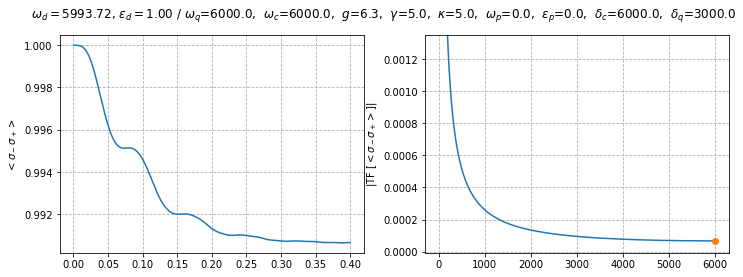

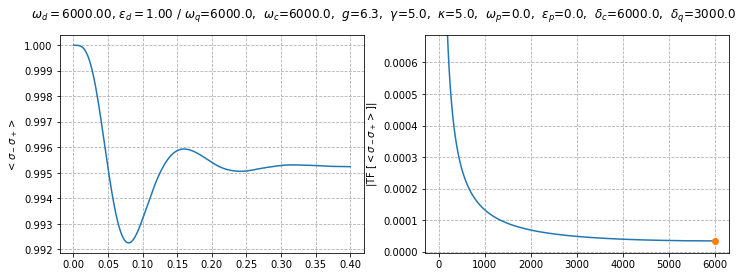

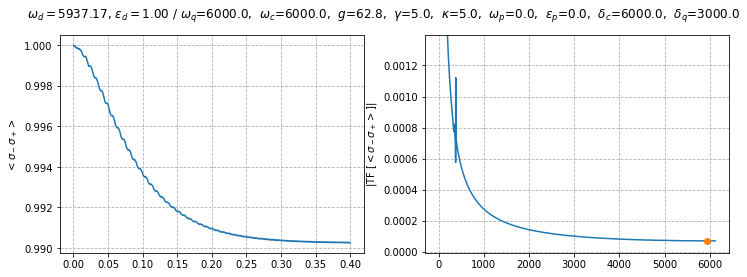

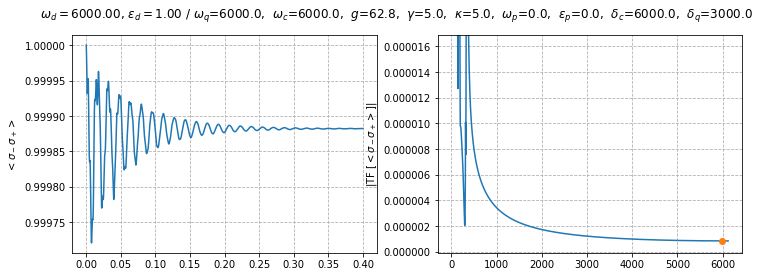

In [2]:
''' Vacuum Rabi Splitting   '''

glist = np.array([1,10])

printing = True
wdriv_list, s_abs_list = [],[]
for ii, g in enumerate(glist):
    param = parameters(w_cav=6e3,w_qubit=6e3,g=g)
    wdriv, s_abs = absorption_spectrum(param, N=21, sp=2, printing=printing)
    wdriv_list.append(wdriv)
    s_abs_list.append(s_abs)
print('done')


Text(0.5, 0, '$g/2\\pi$')

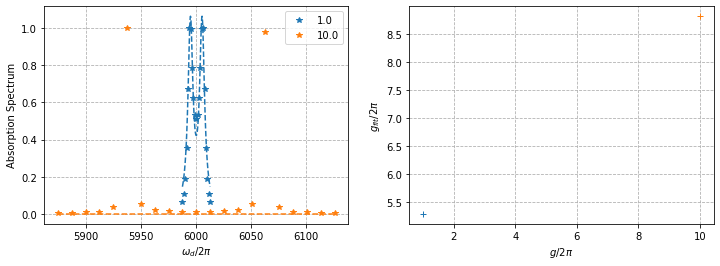

In [5]:
''' Plotting '''

fig, ax = plt.subplots(1,2, figsize=(12,4))
for ii, g in enumerate(glist[:]):
    wdriv = wdriv_list[ii]
    s_abs = s_abs_list[ii]
    popt, pcov = sc.curve_fit(func_double_lor, wdriv, s_abs,
                              p0=[param.args['w_qubit'],param.args['gamma'],1,g])
    wdriv_th = np.linspace(wdriv[0], wdriv[-1], 101)
    ax[0].plot(wdriv/2/np.pi, s_abs, '*', label='%.1f'%(g/2/np.pi), color='C'+str(ii))
    ax[0].plot(wdriv_th/2/np.pi, func_double_lor(wdriv_th,*popt)/popt[2], '--', color='C'+str(ii))
    ax[1].plot(g/2/np.pi, popt[3]/2/np.pi, '+')
ax[0].set_ylabel(r'Absorption Spectrum')
ax[0].grid(linestyle='--')
ax[0].set_xlabel(r'$\omega_d/2\pi$')
ax[0].legend()
ax[1].set_ylabel(r'$g_{fit}/2\pi$')
ax[1].grid(linestyle='--')
ax[1].set_xlabel(r'$g/2\pi$')

gamma=5.0,  kappa=5.0,  g=0.1,  wq=11999.8,  wc=6000.0,  wp=11800.0,  ep=98.0,  dcav=6000.0,  dqbit=0.0
{'e_drive': 6.283185307179586, 'w_drive': array([75302.71804895, 75321.56760487, 75340.41716079, 75359.26671671,
       75378.11627264, 75396.96582856, 75415.81538448, 75434.6649404 ,
       75453.51449632, 75472.36405224, 75491.21360817]), 'tstep': 4.1615341752169e-05, 'tmax': 0.2, 'nopt': 9610, 'n': 5000, 'times': array([0.00000000e+00, 4.16153418e-05, 8.32306835e-05, ...,
       2.07993478e-01, 2.08035093e-01, 2.08076709e-01])}
5000 bins:  68.8 s - nmax reached  9610
done


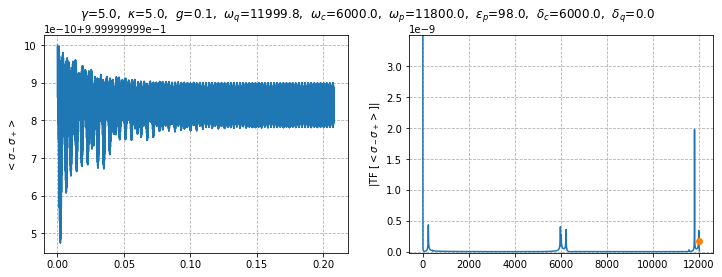

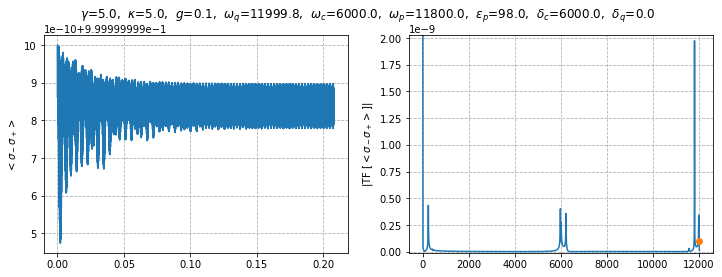

In [180]:
''' Figure 1 '''

param = parameters(w_cav=6e3)
param.Leroux(dpump=1e2, SdB=10)
#wcav  = 2*np.pi*6e3
#dpump = 2*np.pi*1e2
#SdB   = [5]
print(param.print_args('inline'))
times = param.time_gen()
print(param.driv)

printing = True
wdriv, s_abs = absorption_spectrum(param, N=11, sp=3, printing=printing)
print('done')

In [178]:
print(param.Omega()/2/np.pi)

5999.799805745673


0.9722188215365946


Text(0.5, 0, '$g/2\\pi$')

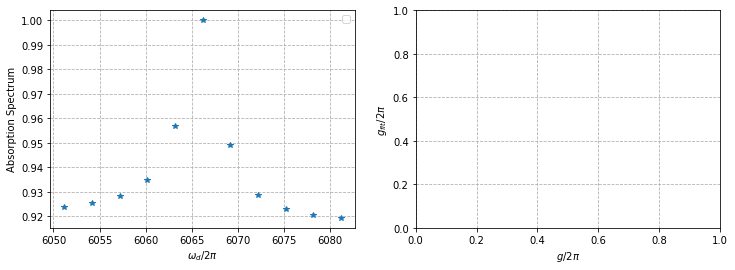

In [36]:
''' Plotting '''

fig, ax = plt.subplots(1,2, figsize=(12,4))
for ii, S in enumerate(SdB[:]):
    wdriv = wdriv_list[ii]
    s_abs = s_abs_list[ii]
    Leroux1(args, wcav, dpump, S)
    #popt, pcov = sc.curve_fit(func_double_lor, wdriv, s_abs, p0=[wqbit,gamma,1,g])
    wdriv_th = np.linspace(wdriv[0], wdriv[-1], 101)
    ax[0].plot(wdriv/2/np.pi, s_abs, '*') #, label='%.1f'%(g/2/np.pi), color='C'+str(ii))
   # ax[0].plot(wdriv_th/2/np.pi, func_double_lor(wdriv_th,*popt)/popt[2], '--', color='C'+str(ii))
 #   ax[1].plot(g/2/np.pi, popt[3]/2/np.pi, '+')
ax[0].set_ylabel(r'Absorption Spectrum')
ax[0].grid(linestyle='--')
ax[0].set_xlabel(r'$\omega_d/2\pi$')
ax[0].legend()
ax[1].set_ylabel(r'$g_{fit}/2\pi$')
ax[1].grid(linestyle='--')
ax[1].set_xlabel(r'$g/2\pi$')

In [2]:
import numpy as np

In [13]:
np.arctanh(1-1e-15)

17.616361586450413

In [6]:
10*np.log10(20)*0.2

2.6020599913279625

In [12]:
np.tanh(np.log(10*np.log10(20)))*100

98.82538050817658

In [37]:
args

{'w_qubit': 38114.93498777478,
 'w_cav': 37699.11184307752,
 'w_drive': 38209.182767382474,
 'e_drive': 6.283185307179586,
 'gamma': 31.41592653589793,
 'kappa': 31.41592653589793,
 'w_pump': 74141.58662471912,
 'e_pump': 603.1131509603587,
 'g': 0.6283185307179586}

In [139]:
a = parameters(w_cav=2)
print(a.print_args('inline'))
print(a.Omega()/2/np.pi)
a.update(w_cav=3, g=1)
print(a.print_args('inline'))
print(a.Omega()/2/np.pi)

gamma=5.0,  kappa=5.0,  g=0.1,  wq=0.0,  wc=2.0,  wp=0.0,  ep=0.0,  dcav=2.0,  dqbit=0.0
1.3236061786117177
gamma=5.0,  kappa=5.0,  g=1.0,  wq=0.0,  wc=3.0,  wp=0.0,  ep=0.0,  dcav=3.0,  dqbit=0.0
1.9854092679175765


In [140]:
print(a.args)

{'gamma': 31.41592653589793, 'kappa': 31.41592653589793, 'g': 6.283185307179586, 'w_qubit': 0.0, 'w_cav': 18.84955592153876, 'w_pump': 0.0, 'e_pump': 0.0, 'd_cav': 18.84955592153876, 'd_qubit': 0.0}


In [136]:
a = {'zob':2, 'zooob':4}
b = {'zboub':3}
print(a,b,{'zob':a['zob'], **b})

{'zob': 2, 'zooob': 4} {'zboub': 3} {'zob': 2, 'zboub': 3}
